In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
train = pd.read_csv('cleaned_train_df.csv')
train_encoded = pd.get_dummies(train, columns=train.select_dtypes(include=['object']).columns, drop_first=True)

# separate target and features
target = train_encoded['SalePrice']
features = train_encoded.drop(columns=['SalePrice', 'Id'])

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the linear regression 
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate RMSE manually if 'squared' argument is not supported
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root-Mean-Squared-Error (RMSE): {rmse}")

Root-Mean-Squared-Error (RMSE): 25639.618069541837


In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model with scaled features
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred1 = model.predict(X_test_scaled)
mse1 = mean_squared_error(y_test, y_pred1)
rmse = np.sqrt(mse1)
print(f"Root-Mean-Squared-Error (RMSE): {rmse}")


Root-Mean-Squared-Error (RMSE): 38070.79659211035


# Randomforest Regressor

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Step 1: PolynomialFeatures with interaction_only
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Step 2: Scaling (optional for RandomForest, but ok)
scaler = StandardScaler()
X_poly_train_scaled = scaler.fit_transform(X_poly_train)
X_poly_test_scaled = scaler.transform(X_poly_test)

param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 7, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_leaf_nodes': [30, 50, 70],
    'max_features': ['sqrt', 'log2']
}

search_rf = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42
)

search_rf.fit(X_poly_train_scaled, y_train)
best_rf_model = search_rf.best_estimator_

# Step 4: Prediction and evaluation
y_pred_rf = best_rf_model.predict(X_poly_test_scaled)

mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf}")

Random Forest MSE: 470884794.3245445


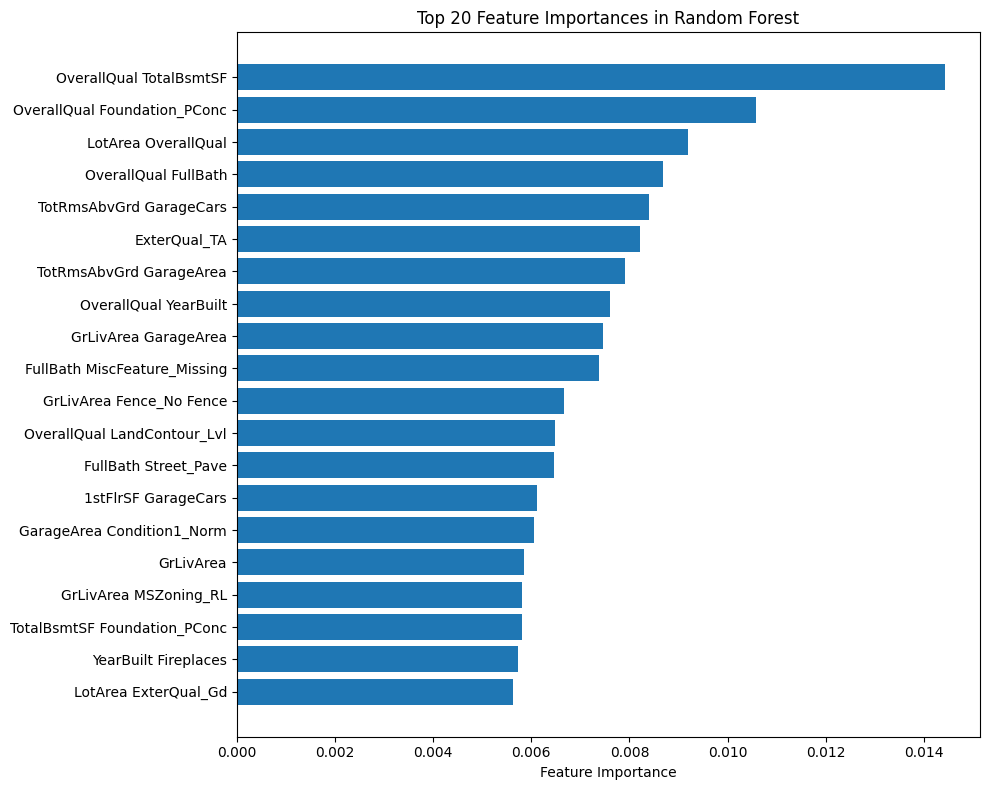

In [29]:
# Get real feature names
feature_names = poly.get_feature_names_out(X_train.columns)

import numpy as np
import matplotlib.pyplot as plt

# Calculate feature importances from the trained Random Forest model
importances = best_rf_model.feature_importances_

# Sort importances and select top N features
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10,8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])  # <--- Use real names here
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances in Random Forest')
plt.tight_layout()
plt.show()


In [30]:
threshold = 0.001
important_indices = np.where(importances > threshold)[0]

X_train_important = X_poly_train_scaled[:, important_indices]
X_test_important = X_poly_test_scaled[:, important_indices]

# Retrain the RandomForest
rf_model_reduced = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_reduced.fit(X_train_important, y_train)
y_pred_rf_reduced = rf_model_reduced.predict(X_test_important)

# Evaluate
mse_rf_reduced = mean_squared_error(y_test, y_pred_rf_reduced)
print(f"Reduced Random Forest MSE: {mse_rf_reduced}")

Reduced Random Forest MSE: 424384459.22633475


In [31]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Scaling
scaler = StandardScaler()
X_poly_train_scaled = scaler.fit_transform(X_poly_train)
X_poly_test_scaled = scaler.transform(X_poly_test)

# RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'
)

# Train on scaled polynomial features
rf_random.fit(X_poly_train_scaled, y_train)

print(f"Best parameters found: {rf_random.best_params_}")
rf_model_best = rf_random.best_estimator_
y_pred_grid = rf_model_best.predict(X_poly_test_scaled)

# Evaluation
mse_grid = mean_squared_error(y_test, y_pred_grid)
rmse_grid = np.sqrt(mse_grid)
r2_grid = r2_score(y_test, y_pred_grid)

print(f"Grid Search RMSE: {rmse_grid}")
print(f"Grid Search R2: {r2_grid}")

# Best parameters found: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
# Grid Search RMSE: 20436.415760031934
# Grid Search R2: 0.8656961905642439

Best parameters found: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Grid Search RMSE: 20436.415760031934
Grid Search R2: 0.8656961905642439


In [32]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score

# 1. Log-transform target variable
y_train_log = np.log1p(y_train)

# 2. Define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# 3. Hyperparameter space
param_grid_svr = {
    'svr__kernel': ['linear', 'rbf'],
    'svr__C': np.logspace(-2, 3, 6),
    'svr__gamma': [0.001, 0.1, 'scale'],
    'svr__degree': [2, 3, 4]
}

# 4. Cross-validation strategy
cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=42)

# 5. RandomizedSearchCV with neg_mean_squared_error (on log scale)
search_svr = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid_svr,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1  
)

# 6. Fit model on log-transformed target
search_svr.fit(X_train_important, y_train_log)
best_svr_model = search_svr.best_estimator_

# 7. Predict and inverse-transform
y_pred_train_log = best_svr_model.predict(X_train_important)
y_pred_test_log = best_svr_model.predict(X_test_important)

y_pred_train = np.expm1(y_pred_train_log)
y_pred_test = np.expm1(y_pred_test_log)

# 8. Calculate metrics in original scale
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)
print("Train R2:", r2_score(y_train, y_pred_train))
print("Test R2:", r2_score(y_test, y_pred_test))

Train RMSE: 17356.374798715293
Test RMSE: 19518.11790555284
Train R2: 0.9293840243770133
Test R2: 0.8774947370562185


### Apply to the test.csv

In [33]:
cleaned_test_df = pd.read_csv('cleaned_test_df.csv')

X_test_raw = pd.get_dummies(cleaned_test_df.drop(columns=['Id']))
X_test_raw = X_test_raw.reindex(columns=X_train.columns, fill_value=0)

X_poly_test = poly.transform(X_test_raw)
X_poly_test_scaled = scaler.transform(X_poly_test)
X_cleaned_test_important = X_poly_test_scaled[:, important_indices]

predicted_saleprice = best_svr_model.predict(X_cleaned_test_important)

submission = pd.DataFrame({
    'Id': cleaned_test_df['Id'],
    'SalePrice': predicted_saleprice
})
submission.to_csv('submission_svr.csv', index=False)

In [34]:
cleaned_test_df = pd.read_csv('cleaned_test_df.csv')

X_test_raw = pd.get_dummies(cleaned_test_df.drop(columns=['Id']))
X_test_raw = X_test_raw.reindex(columns=features.columns, fill_value=0)

X_poly_test = poly.transform(X_test_raw)
X_poly_test_scaled = scaler.transform(X_poly_test)

# Ensure consistent feature selection
if X_poly_test_scaled.shape[1] < max(important_indices) + 1:
    raise ValueError(f"Feature mismatch: Test set has {X_poly_test_scaled.shape[1]} features, "
                     f"but the model expects at least {max(important_indices) + 1} features.")

X_cleaned_test_important = X_poly_test_scaled[:, important_indices]

predicted_saleprice = rf_model_reduced.predict(X_cleaned_test_important)

submission = pd.DataFrame({
    'Id': cleaned_test_df['Id'],
    'SalePrice': predicted_saleprice
})
submission.to_csv('submission_random.csv', index=False)